In [1]:
import sys

sys.path.append("../../")

from astronn import datasets
from astronn import models

import matplotlib.pyplot as plt

from matplotlib.pyplot import figure
from scipy.signal import find_peaks, peak_widths


seed_value = 12345
import os

os.environ["PYTHONHASHSEED"] = str(seed_value)
import random
import numpy as np

random.seed(seed_value)
np.random.seed(seed_value)
import tensorflow as tf

tf.random.set_seed(seed_value)

# Star model to train
star_models = datasets.starmodels()

df_train = star_models.load(
    "/home/roberto/Downloads/evolutionTracks_line/parts_train/*_norm",
    batch_size=250,
    add_noise=False,
)
df_validation = star_models.load(
    "/home/roberto/Downloads/evolutionTracks_line/parts_validation/*_norm",
    batch_size=150,
    add_noise=False,
)


# Read datasets of preprocessed real stars to test
df_ds = datasets.deltascuti()
deltascuti = df_ds.load(
    "../../astronn/data/deltascuti/preprocessed/*_norm", batch_size=1
)
bedding_stars = datasets.bedding()
df_bedding = bedding_stars.load("../data/bedding/preprocessed/*_norm", batch_size=1)

# Get stars
ds_stars = [star for star in deltascuti.take(11)]
ds_bedding = [star for star in df_bedding.take(57)]

Using TensorFlow backend.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
"""

# Learn and autoencoder from star models
from tensorflow.keras import layers
from keras.models import load_model

encoding_dim = 2

autoencoder = tf.keras.Sequential(
    [
        layers.Input(shape=(400, 2)),
        layers.Flatten(),
        layers.Dense(200),
        layers.Dense(
            encoding_dim,
            name="lattent",
            activity_regularizer=tf.keras.regularizers.l1(10e-5),
        ),
        layers.Dense(200),
        layers.Dense(800),
        layers.Reshape((400, 2)),
    ]
)

# This model maps an input to its reconstruction
opt = tf.keras.optimizers.Adam(learning_rate=0.1)
autoencoder.compile(loss="binary_crossentropy", optimizer=opt, metrics=["mse"])
autoencoder.summary()

autoencoder.fit(
    df_train, steps_per_epoch=40, epochs=10, verbose=True,
)
"""

'\n\n# Learn and autoencoder from star models\nfrom tensorflow.keras import layers\nfrom keras.models import load_model\n\nencoding_dim = 2\n\nautoencoder = tf.keras.Sequential(\n    [\n        layers.Input(shape=(400, 2)),\n        layers.Flatten(),\n        layers.Dense(200),\n        layers.Dense(\n            encoding_dim,\n            name="lattent",\n            activity_regularizer=tf.keras.regularizers.l1(10e-5),\n        ),\n        layers.Dense(200),\n        layers.Dense(800),\n        layers.Reshape((400, 2)),\n    ]\n)\n\n# This model maps an input to its reconstruction\nopt = tf.keras.optimizers.Adam(learning_rate=0.1)\nautoencoder.compile(loss="binary_crossentropy", optimizer=opt, metrics=["mse"])\nautoencoder.summary()\n\nautoencoder.fit(\n    df_train, steps_per_epoch=40, epochs=10, verbose=True,\n)\n'

In [4]:
"""
count = 0
for star in df_train.take(1):
    plt.plot(star[0][0, :, 0])
    plt.plot(star[0][0, :, 1])
    plt.show()
    
plt.plot(autoencoder.predict(star[0])[0])

autoencoder.get_layer("lattent").output
autoencoder.save("/tmp/autoencoder")
"""

'\ncount = 0\nfor star in df_train.take(1):\n    plt.plot(star[0][0, :, 0])\n    plt.plot(star[0][0, :, 1])\n    plt.show()\n    \nplt.plot(autoencoder.predict(star[0])[0])\n\nautoencoder.get_layer("lattent").output\nautoencoder.save("/tmp/autoencoder")\n'

In [5]:
#model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#    filepath="/tmp/model_checkpoint",
#    save_weights_only=True,
#    monitor='val_acc',
#    mode='max',
#    save_best_only=True)

In [6]:
def get_peak_width(position, peaks, peaks_width, peaks_sorted_by_prob):
    """
    """
    peak_id = np.where(probs == peaks_sorted_by_prob[position])[0][0]
    return (peak_id, peaks_width[0][np.where(peaks == peak_id)[0][0]])

In [7]:
results = {}
results["loss"] = []
results["accuracy"] = []
results["val_loss"] = []
results["val_accuracy"] = []

results["binaries_errors"] = []
results["binaries_errors_top2"] = []
results["binaries_mse"] = []

results["bedding_errors"] = []
results["bedding_errors_top2"] = []
results["bedding_mse"] = []

weighted_array_train = np.array([np.float32(i) for i in range(100)])
class_weight_dict = dict(enumerate(weighted_array_train))

higher_n_probs = 10
loops = 1
for loop in range(loops):
    print("Loop %s" % loop)
    sepconv_mod = models.separableconvnn()  # init model
    sepconv_mod.compile(learning_rate=0.001)  # compile model
    for ep in range(400 + 1):
        print("Episode %s" % ep)
        history = sepconv_mod.model.fit(
            # df_train,
            df_train,
            validation_data=df_validation,
            validation_steps=1,
            steps_per_epoch=20,
            epochs=1,
            verbose=True,
        )

        if ep % 20 == 0:
            sepconv_mod.save("/tmp/sepconvnn_tmp_dos_%s" % ep)  # tmp model save
        # Add prediction
        for star in ds_stars:
            if star[0].numpy()[0].decode("utf-8") not in results:
                results[star[0].numpy()[0].decode("utf-8")] = {}
            # results[star[0].numpy()[0].decode("utf-8")].append(sepconv_mod.model.predict_classes(star[1]))
            probs = sepconv_mod.model.predict_proba(star[1]).ravel()
            for idx, val in np.ndenumerate(probs.argsort()[-higher_n_probs:][::-1]):
                if idx not in results[star[0].numpy()[0].decode("utf-8")]:
                    results[star[0].numpy()[0].decode("utf-8")][idx] = []
                results[star[0].numpy()[0].decode("utf-8")][idx].append(val)
        # Get mean errors on observation stars

        bests_plot = []
        bests_ys = []
        error = []
        error_top2 = []

        for star in ds_stars:
            target = np.where(star[2].numpy().flat == 1)[0].flat[0]

            probs = sepconv_mod.model.predict_proba(star[1])[0]
            peaks, _ = find_peaks(probs, height=0, distance=10)
            peaks_width = peak_widths(probs, peaks)
            peaks_sorted_by_prob = np.sort(probs[peaks])[::-1]
            best_peak, best_peak_width = get_peak_width(
                0, peaks, peaks_width, peaks_sorted_by_prob
            )
            error.append(best_peak - target)

            bests_plot.append(best_peak)
            bests_ys.append(target)

            best_peak_top2, best_peak_width = get_peak_width(
                1, peaks, peaks_width, peaks_sorted_by_prob
            )
            if (
                np.argmin([np.abs(best_peak - target), np.abs(best_peak_top2 - target)])
                == 0
            ):
                error_top2.append(best_peak - target)
            else:
                error_top2.append(best_peak_top2 - target)

        results["binaries_errors"].append(np.mean(error))
        results["binaries_mse"].append(np.mean(np.power(error, 2)))
        results["binaries_errors_top2"].append(np.mean(error_top2))

        error = []
        error_top2 = []

        for star in ds_bedding:
            target = np.where(star[2].numpy().flat == 1)[0].flat[0] / 0.0864

            probs = sepconv_mod.model.predict_proba(star[1])[0]
            peaks, _ = find_peaks(probs, height=0, distance=10)
            peaks_width = peak_widths(probs, peaks)
            peaks_sorted_by_prob = np.sort(probs[peaks])[::-1]
            best_peak, best_peak_width = get_peak_width(
                0, peaks, peaks_width, peaks_sorted_by_prob
            )
            error.append(best_peak - target)

            best_peak_top2, best_peak_width = get_peak_width(
                1, peaks, peaks_width, peaks_sorted_by_prob
            )
            if (
                np.argmin([np.abs(best_peak - target), np.abs(best_peak_top2 - target)])
                == 0
            ):
                error_top2.append(best_peak - target)
            else:
                error_top2.append(best_peak_top2 - target)

        # Errors calculation

        results["bedding_errors"].append(np.mean(error))
        results["bedding_mse"].append(np.mean(np.power(error, 2)))
        results["bedding_errors_top2"].append(np.mean(error_top2))

        results["loss"].append(history.history["loss"][0])
        results["accuracy"].append(history.history["accuracy"][0])
        results["val_loss"].append(history.history["val_loss"][0])
        results["val_accuracy"].append(history.history["val_accuracy"][0])

        # Print every ep epoch
        if ep % 10 == 0 and False:
            x = [i for i in range(len(results["binaries_errors"]))]
            plt.errorbar(x, results["binaries_errors"], 0, label="11-bs top1")
            plt.errorbar(
                x,
                results["binaries_errors_top2"],
                0,
                marker="x",
                color="lightblue",
                label="11-bs (best top1,2)",
            )
            plt.errorbar(
                x, results["bedding_errors"], 0, color="green", label="77-Bedding top1"
            )
            plt.errorbar(
                x,
                results["bedding_errors_top2"],
                0,
                marker="x",
                color="lightgreen",
                label="77-Bedding (best of top1,2)",
            )
            plt.title("error on real Data")
            plt.axhline(y=0, color="grey", linestyle="-", label="0 abs error")
            plt.ylabel("abs error")
            plt.xlabel("epoch")
            plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
            plt.show()

            plt.plot(results["binaries_mse"], label="11-bs top1")
            plt.plot(results["bedding_mse"], label="77-Bedding top1", color="green")
            plt.title("acc mse")
            plt.ylabel("mse")
            plt.xlabel("epoch")
            plt.legend(loc="upper left")
            plt.show()

            plt.scatter(bests_ys, bests_plot)
            plt.xlim(0, 100)
            plt.ylim(0, 100)
            plt.show()

            """
            plt.plot(results["loss"])
            plt.plot(results["val_loss"])
            plt.title("model loss")
            plt.ylabel("loss")
            plt.xlabel("epoch")
            plt.legend(["train", "validation"], loc="upper left")
            plt.show()

            plt.plot(results["accuracy"])
            plt.plot(results["val_accuracy"])
            plt.title("model accuracy")
            plt.ylabel("accuracy")
            plt.xlabel("epoch")
            plt.legend(["train", "validation"], loc="upper left")
            plt.show()
            """

Loop 0
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 399, 10)           50        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 395, 20)           1020      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 197, 20)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 197, 20)           80        
_________________________________________________________________
dropout (Dropout)            (None, 197, 20)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 183, 10)           3010      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 164, 10)     

/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Episode 1
20/20 [==============================] - 3s 135ms/step - loss: 0.0987 - accuracy: 0.0276 - val_loss: 0.1784 - val_accuracy: 0.0067
Episode 2
20/20 [==============================] - 3s 131ms/step - loss: 0.0680 - accuracy: 0.0392 - val_loss: 0.1629 - val_accuracy: 0.0267
Episode 3
20/20 [==============================] - 3s 134ms/step - loss: 0.0595 - accuracy: 0.0624 - val_loss: 0.1917 - val_accuracy: 0.0533
Episode 4
20/20 [==============================] - 3s 132ms/step - loss: 0.0563 - accuracy: 0.0752 - val_loss: 0.2219 - val_accuracy: 0.0667
Episode 5
20/20 [==============================] - 3s 135ms/step - loss: 0.0523 - accuracy: 0.0996 - val_loss: 0.2489 - val_accuracy: 0.0600
Episode 6
20/20 [==============================] - 3s 131ms/step - loss: 0.0504 - accuracy: 0.1206 - val_loss: 0.2694 - val_accuracy: 0.0733
Episode 7
20/20 [==============================] - 3s 135ms/step - loss: 0.0495 - accuracy: 0.1250 - val_loss: 0.2833 - val_accuracy: 0.0733
Episode 8
20/

/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Episode 21
20/20 [==============================] - 3s 131ms/step - loss: 0.0386 - accuracy: 0.2380 - val_loss: 0.3433 - val_accuracy: 0.1267
Episode 22
20/20 [==============================] - 3s 134ms/step - loss: 0.0381 - accuracy: 0.2488 - val_loss: 0.3441 - val_accuracy: 0.1467
Episode 23
20/20 [==============================] - 3s 130ms/step - loss: 0.0386 - accuracy: 0.2312 - val_loss: 0.3333 - val_accuracy: 0.0733
Episode 24
20/20 [==============================] - 3s 132ms/step - loss: 0.0382 - accuracy: 0.2374 - val_loss: 0.3307 - val_accuracy: 0.1333
Episode 25
20/20 [==============================] - 3s 131ms/step - loss: 0.0379 - accuracy: 0.2360 - val_loss: 0.3226 - val_accuracy: 0.1600
Episode 26
20/20 [==============================] - 3s 133ms/step - loss: 0.0373 - accuracy: 0.2562 - val_loss: 0.2836 - val_accuracy: 0.2067
Episode 27
20/20 [==============================] - 3s 133ms/step - loss: 0.0374 - accuracy: 0.2362 - val_loss: 0.2812 - val_accuracy: 0.1400
Episod

/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Episode 41
20/20 [==============================] - 3s 134ms/step - loss: 0.0350 - accuracy: 0.2766 - val_loss: 0.0372 - val_accuracy: 0.3333
Episode 42
20/20 [==============================] - 3s 131ms/step - loss: 0.0352 - accuracy: 0.2812 - val_loss: 0.0327 - val_accuracy: 0.3200
Episode 43
20/20 [==============================] - 3s 134ms/step - loss: 0.0348 - accuracy: 0.2868 - val_loss: 0.0353 - val_accuracy: 0.2733
Episode 44
20/20 [==============================] - 3s 132ms/step - loss: 0.0350 - accuracy: 0.2882 - val_loss: 0.0341 - val_accuracy: 0.3000
Episode 45
20/20 [==============================] - 3s 135ms/step - loss: 0.0346 - accuracy: 0.2822 - val_loss: 0.0320 - val_accuracy: 0.3533
Episode 46
20/20 [==============================] - 3s 132ms/step - loss: 0.0349 - accuracy: 0.2834 - val_loss: 0.0308 - val_accuracy: 0.3667
Episode 47
20/20 [==============================] - 3s 135ms/step - loss: 0.0342 - accuracy: 0.2966 - val_loss: 0.0309 - val_accuracy: 0.2533
Episod

/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Episode 61
20/20 [==============================] - 3s 130ms/step - loss: 0.0334 - accuracy: 0.3080 - val_loss: 0.0308 - val_accuracy: 0.3533
Episode 62
20/20 [==============================] - 3s 134ms/step - loss: 0.0333 - accuracy: 0.3032 - val_loss: 0.0291 - val_accuracy: 0.2867
Episode 63
20/20 [==============================] - 3s 131ms/step - loss: 0.0332 - accuracy: 0.3182 - val_loss: 0.0305 - val_accuracy: 0.3267
Episode 64
20/20 [==============================] - 3s 135ms/step - loss: 0.0333 - accuracy: 0.3040 - val_loss: 0.0303 - val_accuracy: 0.3667
Episode 65
20/20 [==============================] - 3s 130ms/step - loss: 0.0326 - accuracy: 0.3230 - val_loss: 0.0282 - val_accuracy: 0.4067
Episode 66
20/20 [==============================] - 3s 135ms/step - loss: 0.0328 - accuracy: 0.3280 - val_loss: 0.0290 - val_accuracy: 0.3800
Episode 67
20/20 [==============================] - 3s 133ms/step - loss: 0.0331 - accuracy: 0.3110 - val_loss: 0.0302 - val_accuracy: 0.3267
Episod

/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Episode 81
20/20 [==============================] - 3s 135ms/step - loss: 0.0323 - accuracy: 0.3210 - val_loss: 0.0301 - val_accuracy: 0.3667
Episode 82
20/20 [==============================] - 3s 131ms/step - loss: 0.0322 - accuracy: 0.3378 - val_loss: 0.0288 - val_accuracy: 0.3933
Episode 83
20/20 [==============================] - 3s 135ms/step - loss: 0.0325 - accuracy: 0.3150 - val_loss: 0.0290 - val_accuracy: 0.3867
Episode 84
20/20 [==============================] - 3s 132ms/step - loss: 0.0322 - accuracy: 0.3234 - val_loss: 0.0303 - val_accuracy: 0.4000
Episode 85
20/20 [==============================] - 3s 135ms/step - loss: 0.0321 - accuracy: 0.3362 - val_loss: 0.0294 - val_accuracy: 0.3800
Episode 86
20/20 [==============================] - 3s 129ms/step - loss: 0.0321 - accuracy: 0.3262 - val_loss: 0.0298 - val_accuracy: 0.3200
Episode 87
20/20 [==============================] - 3s 134ms/step - loss: 0.0323 - accuracy: 0.3214 - val_loss: 0.0299 - val_accuracy: 0.3667
Episod

/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Episode 101
20/20 [==============================] - 3s 134ms/step - loss: 0.0317 - accuracy: 0.3314 - val_loss: 0.0286 - val_accuracy: 0.3867
Episode 102
20/20 [==============================] - 3s 134ms/step - loss: 0.0315 - accuracy: 0.3306 - val_loss: 0.0287 - val_accuracy: 0.3733
Episode 103
20/20 [==============================] - 3s 133ms/step - loss: 0.0317 - accuracy: 0.3298 - val_loss: 0.0296 - val_accuracy: 0.3467
Episode 104
20/20 [==============================] - 3s 135ms/step - loss: 0.0310 - accuracy: 0.3548 - val_loss: 0.0293 - val_accuracy: 0.3533
Episode 105
20/20 [==============================] - 3s 135ms/step - loss: 0.0316 - accuracy: 0.3216 - val_loss: 0.0307 - val_accuracy: 0.3733
Episode 106
20/20 [==============================] - 3s 132ms/step - loss: 0.0311 - accuracy: 0.3458 - val_loss: 0.0304 - val_accuracy: 0.3067
Episode 107
20/20 [==============================] - 3s 132ms/step - loss: 0.0312 - accuracy: 0.3432 - val_loss: 0.0281 - val_accuracy: 0.4000

/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Episode 121
20/20 [==============================] - 3s 130ms/step - loss: 0.0310 - accuracy: 0.3438 - val_loss: 0.0290 - val_accuracy: 0.3400
Episode 122
20/20 [==============================] - 3s 133ms/step - loss: 0.0310 - accuracy: 0.3398 - val_loss: 0.0285 - val_accuracy: 0.3733
Episode 123
20/20 [==============================] - 3s 133ms/step - loss: 0.0310 - accuracy: 0.3452 - val_loss: 0.0280 - val_accuracy: 0.4133
Episode 124
20/20 [==============================] - 3s 135ms/step - loss: 0.0308 - accuracy: 0.3572 - val_loss: 0.0290 - val_accuracy: 0.3400
Episode 125
20/20 [==============================] - 3s 135ms/step - loss: 0.0308 - accuracy: 0.3456 - val_loss: 0.0288 - val_accuracy: 0.3733
Episode 126
20/20 [==============================] - 3s 135ms/step - loss: 0.0309 - accuracy: 0.3426 - val_loss: 0.0283 - val_accuracy: 0.4600
Episode 127
20/20 [==============================] - 3s 134ms/step - loss: 0.0308 - accuracy: 0.3450 - val_loss: 0.0281 - val_accuracy: 0.3733

/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Episode 141
20/20 [==============================] - 3s 134ms/step - loss: 0.0309 - accuracy: 0.3548 - val_loss: 0.0277 - val_accuracy: 0.3867
Episode 142
20/20 [==============================] - 3s 134ms/step - loss: 0.0304 - accuracy: 0.3600 - val_loss: 0.0280 - val_accuracy: 0.3667
Episode 143
20/20 [==============================] - 3s 133ms/step - loss: 0.0308 - accuracy: 0.3494 - val_loss: 0.0277 - val_accuracy: 0.3600
Episode 144
20/20 [==============================] - 3s 133ms/step - loss: 0.0304 - accuracy: 0.3692 - val_loss: 0.0295 - val_accuracy: 0.4267
Episode 145
20/20 [==============================] - 3s 134ms/step - loss: 0.0305 - accuracy: 0.3594 - val_loss: 0.0286 - val_accuracy: 0.4067
Episode 146
20/20 [==============================] - 3s 136ms/step - loss: 0.0303 - accuracy: 0.3652 - val_loss: 0.0272 - val_accuracy: 0.4867
Episode 147
20/20 [==============================] - 3s 136ms/step - loss: 0.0306 - accuracy: 0.3508 - val_loss: 0.0290 - val_accuracy: 0.3667

/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Episode 161
20/20 [==============================] - 3s 136ms/step - loss: 0.0302 - accuracy: 0.3674 - val_loss: 0.0278 - val_accuracy: 0.4333
Episode 162
20/20 [==============================] - 3s 132ms/step - loss: 0.0301 - accuracy: 0.3780 - val_loss: 0.0289 - val_accuracy: 0.4133
Episode 163
20/20 [==============================] - 3s 134ms/step - loss: 0.0305 - accuracy: 0.3546 - val_loss: 0.0291 - val_accuracy: 0.3867
Episode 164
20/20 [==============================] - 3s 131ms/step - loss: 0.0303 - accuracy: 0.3526 - val_loss: 0.0272 - val_accuracy: 0.4200
Episode 165
20/20 [==============================] - 3s 135ms/step - loss: 0.0301 - accuracy: 0.3532 - val_loss: 0.0288 - val_accuracy: 0.3600
Episode 166
20/20 [==============================] - 3s 131ms/step - loss: 0.0301 - accuracy: 0.3562 - val_loss: 0.0287 - val_accuracy: 0.4067
Episode 167
20/20 [==============================] - 3s 136ms/step - loss: 0.0302 - accuracy: 0.3632 - val_loss: 0.0286 - val_accuracy: 0.4000

/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Episode 181
20/20 [==============================] - 3s 133ms/step - loss: 0.0300 - accuracy: 0.3572 - val_loss: 0.0274 - val_accuracy: 0.4267
Episode 182
20/20 [==============================] - 3s 134ms/step - loss: 0.0302 - accuracy: 0.3694 - val_loss: 0.0265 - val_accuracy: 0.4067
Episode 183
20/20 [==============================] - 3s 134ms/step - loss: 0.0298 - accuracy: 0.3560 - val_loss: 0.0279 - val_accuracy: 0.3933
Episode 184
20/20 [==============================] - 3s 133ms/step - loss: 0.0303 - accuracy: 0.3556 - val_loss: 0.0288 - val_accuracy: 0.4067
Episode 185
20/20 [==============================] - 3s 131ms/step - loss: 0.0301 - accuracy: 0.3610 - val_loss: 0.0293 - val_accuracy: 0.4067
Episode 186
20/20 [==============================] - 3s 136ms/step - loss: 0.0298 - accuracy: 0.3584 - val_loss: 0.0272 - val_accuracy: 0.4067
Episode 187
20/20 [==============================] - 3s 132ms/step - loss: 0.0301 - accuracy: 0.3610 - val_loss: 0.0285 - val_accuracy: 0.3733

/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Episode 201
20/20 [==============================] - 3s 131ms/step - loss: 0.0299 - accuracy: 0.3770 - val_loss: 0.0289 - val_accuracy: 0.3267
Episode 202
20/20 [==============================] - 3s 135ms/step - loss: 0.0298 - accuracy: 0.3724 - val_loss: 0.0271 - val_accuracy: 0.4333
Episode 203
20/20 [==============================] - 3s 136ms/step - loss: 0.0300 - accuracy: 0.3618 - val_loss: 0.0287 - val_accuracy: 0.3267
Episode 204
20/20 [==============================] - 3s 133ms/step - loss: 0.0300 - accuracy: 0.3612 - val_loss: 0.0285 - val_accuracy: 0.3533
Episode 205
20/20 [==============================] - 3s 134ms/step - loss: 0.0297 - accuracy: 0.3646 - val_loss: 0.0280 - val_accuracy: 0.3933
Episode 206
20/20 [==============================] - 3s 131ms/step - loss: 0.0297 - accuracy: 0.3662 - val_loss: 0.0270 - val_accuracy: 0.4400
Episode 207
20/20 [==============================] - 3s 133ms/step - loss: 0.0299 - accuracy: 0.3680 - val_loss: 0.0273 - val_accuracy: 0.3933

/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Episode 221
20/20 [==============================] - 3s 135ms/step - loss: 0.0297 - accuracy: 0.3622 - val_loss: 0.0273 - val_accuracy: 0.3733
Episode 222
20/20 [==============================] - 3s 135ms/step - loss: 0.0294 - accuracy: 0.3760 - val_loss: 0.0294 - val_accuracy: 0.3333
Episode 223
20/20 [==============================] - 3s 133ms/step - loss: 0.0296 - accuracy: 0.3774 - val_loss: 0.0270 - val_accuracy: 0.3733
Episode 224
20/20 [==============================] - 3s 137ms/step - loss: 0.0296 - accuracy: 0.3766 - val_loss: 0.0270 - val_accuracy: 0.4000
Episode 225
20/20 [==============================] - 3s 134ms/step - loss: 0.0298 - accuracy: 0.3640 - val_loss: 0.0269 - val_accuracy: 0.4000
Episode 226
20/20 [==============================] - 3s 135ms/step - loss: 0.0299 - accuracy: 0.3656 - val_loss: 0.0292 - val_accuracy: 0.3533
Episode 227
20/20 [==============================] - 3s 132ms/step - loss: 0.0296 - accuracy: 0.3784 - val_loss: 0.0286 - val_accuracy: 0.3533

/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Episode 241
20/20 [==============================] - 3s 135ms/step - loss: 0.0292 - accuracy: 0.3794 - val_loss: 0.0277 - val_accuracy: 0.4133
Episode 242
20/20 [==============================] - 3s 131ms/step - loss: 0.0296 - accuracy: 0.3742 - val_loss: 0.0271 - val_accuracy: 0.3333
Episode 243
20/20 [==============================] - 3s 134ms/step - loss: 0.0298 - accuracy: 0.3682 - val_loss: 0.0272 - val_accuracy: 0.4400
Episode 244
20/20 [==============================] - 3s 136ms/step - loss: 0.0295 - accuracy: 0.3798 - val_loss: 0.0279 - val_accuracy: 0.3733
Episode 245
20/20 [==============================] - 3s 134ms/step - loss: 0.0293 - accuracy: 0.3746 - val_loss: 0.0275 - val_accuracy: 0.3600
Episode 246
20/20 [==============================] - 3s 133ms/step - loss: 0.0297 - accuracy: 0.3638 - val_loss: 0.0272 - val_accuracy: 0.4267
Episode 247
20/20 [==============================] - 3s 133ms/step - loss: 0.0293 - accuracy: 0.3798 - val_loss: 0.0290 - val_accuracy: 0.4133

/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Episode 261
20/20 [==============================] - 3s 135ms/step - loss: 0.0293 - accuracy: 0.3802 - val_loss: 0.0282 - val_accuracy: 0.3800
Episode 262
20/20 [==============================] - 3s 142ms/step - loss: 0.0297 - accuracy: 0.3688 - val_loss: 0.0272 - val_accuracy: 0.3800
Episode 263
20/20 [==============================] - 3s 135ms/step - loss: 0.0294 - accuracy: 0.3720 - val_loss: 0.0262 - val_accuracy: 0.4133
Episode 264
20/20 [==============================] - 3s 132ms/step - loss: 0.0298 - accuracy: 0.3580 - val_loss: 0.0276 - val_accuracy: 0.3333
Episode 265
20/20 [==============================] - 3s 135ms/step - loss: 0.0292 - accuracy: 0.3766 - val_loss: 0.0266 - val_accuracy: 0.5067
Episode 266
20/20 [==============================] - 3s 131ms/step - loss: 0.0294 - accuracy: 0.3778 - val_loss: 0.0281 - val_accuracy: 0.4067
Episode 267
20/20 [==============================] - 3s 134ms/step - loss: 0.0294 - accuracy: 0.3708 - val_loss: 0.0265 - val_accuracy: 0.5067

/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Episode 281
20/20 [==============================] - 3s 130ms/step - loss: 0.0295 - accuracy: 0.3670 - val_loss: 0.0267 - val_accuracy: 0.3800
Episode 282
20/20 [==============================] - 3s 134ms/step - loss: 0.0294 - accuracy: 0.3830 - val_loss: 0.0280 - val_accuracy: 0.3600
Episode 283
20/20 [==============================] - 3s 135ms/step - loss: 0.0292 - accuracy: 0.3736 - val_loss: 0.0288 - val_accuracy: 0.3800
Episode 284
20/20 [==============================] - 3s 131ms/step - loss: 0.0293 - accuracy: 0.3748 - val_loss: 0.0269 - val_accuracy: 0.4400
Episode 285
20/20 [==============================] - 3s 134ms/step - loss: 0.0295 - accuracy: 0.3708 - val_loss: 0.0261 - val_accuracy: 0.4133
Episode 286
20/20 [==============================] - 3s 132ms/step - loss: 0.0293 - accuracy: 0.3816 - val_loss: 0.0270 - val_accuracy: 0.4333
Episode 287
20/20 [==============================] - 3s 133ms/step - loss: 0.0291 - accuracy: 0.3740 - val_loss: 0.0286 - val_accuracy: 0.3733

/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Episode 301
20/20 [==============================] - 3s 134ms/step - loss: 0.0292 - accuracy: 0.3812 - val_loss: 0.0285 - val_accuracy: 0.3667
Episode 302
20/20 [==============================] - 3s 131ms/step - loss: 0.0293 - accuracy: 0.3814 - val_loss: 0.0299 - val_accuracy: 0.3400
Episode 303
20/20 [==============================] - 3s 135ms/step - loss: 0.0294 - accuracy: 0.3806 - val_loss: 0.0262 - val_accuracy: 0.4000
Episode 304
20/20 [==============================] - 3s 132ms/step - loss: 0.0293 - accuracy: 0.3766 - val_loss: 0.0288 - val_accuracy: 0.3467
Episode 305
20/20 [==============================] - 3s 136ms/step - loss: 0.0292 - accuracy: 0.3912 - val_loss: 0.0258 - val_accuracy: 0.4133
Episode 306
20/20 [==============================] - 3s 134ms/step - loss: 0.0296 - accuracy: 0.3710 - val_loss: 0.0285 - val_accuracy: 0.4000
Episode 307
20/20 [==============================] - 3s 133ms/step - loss: 0.0293 - accuracy: 0.3876 - val_loss: 0.0272 - val_accuracy: 0.4067

/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Episode 321
20/20 [==============================] - 3s 135ms/step - loss: 0.0293 - accuracy: 0.3796 - val_loss: 0.0256 - val_accuracy: 0.4600
Episode 322
20/20 [==============================] - 3s 132ms/step - loss: 0.0295 - accuracy: 0.3694 - val_loss: 0.0280 - val_accuracy: 0.3867
Episode 323
20/20 [==============================] - 3s 133ms/step - loss: 0.0293 - accuracy: 0.3824 - val_loss: 0.0291 - val_accuracy: 0.3000
Episode 324
20/20 [==============================] - 3s 134ms/step - loss: 0.0292 - accuracy: 0.3778 - val_loss: 0.0265 - val_accuracy: 0.4200
Episode 325
20/20 [==============================] - 3s 134ms/step - loss: 0.0291 - accuracy: 0.3810 - val_loss: 0.0289 - val_accuracy: 0.3467
Episode 326
20/20 [==============================] - 3s 136ms/step - loss: 0.0291 - accuracy: 0.3706 - val_loss: 0.0283 - val_accuracy: 0.3333
Episode 327
20/20 [==============================] - 3s 133ms/step - loss: 0.0293 - accuracy: 0.3784 - val_loss: 0.0267 - val_accuracy: 0.4133

/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Episode 341
20/20 [==============================] - 3s 132ms/step - loss: 0.0293 - accuracy: 0.3616 - val_loss: 0.0269 - val_accuracy: 0.4333
Episode 342
20/20 [==============================] - 3s 134ms/step - loss: 0.0289 - accuracy: 0.3782 - val_loss: 0.0268 - val_accuracy: 0.4000
Episode 343
20/20 [==============================] - 3s 131ms/step - loss: 0.0289 - accuracy: 0.3868 - val_loss: 0.0274 - val_accuracy: 0.3933
Episode 344
20/20 [==============================] - 3s 134ms/step - loss: 0.0293 - accuracy: 0.3704 - val_loss: 0.0285 - val_accuracy: 0.4000
Episode 345
20/20 [==============================] - 3s 133ms/step - loss: 0.0297 - accuracy: 0.3654 - val_loss: 0.0256 - val_accuracy: 0.4267
Episode 346
20/20 [==============================] - 3s 132ms/step - loss: 0.0292 - accuracy: 0.3794 - val_loss: 0.0282 - val_accuracy: 0.3867
Episode 347
20/20 [==============================] - 3s 132ms/step - loss: 0.0291 - accuracy: 0.3828 - val_loss: 0.0281 - val_accuracy: 0.3600

/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Episode 361
20/20 [==============================] - 3s 135ms/step - loss: 0.0292 - accuracy: 0.3778 - val_loss: 0.0294 - val_accuracy: 0.3333
Episode 362
20/20 [==============================] - 3s 131ms/step - loss: 0.0292 - accuracy: 0.3744 - val_loss: 0.0286 - val_accuracy: 0.3400
Episode 363
20/20 [==============================] - 3s 134ms/step - loss: 0.0291 - accuracy: 0.3728 - val_loss: 0.0280 - val_accuracy: 0.3800
Episode 364
20/20 [==============================] - 3s 134ms/step - loss: 0.0289 - accuracy: 0.3910 - val_loss: 0.0271 - val_accuracy: 0.3600
Episode 365
20/20 [==============================] - 3s 133ms/step - loss: 0.0290 - accuracy: 0.3894 - val_loss: 0.0280 - val_accuracy: 0.3533
Episode 366
20/20 [==============================] - 3s 134ms/step - loss: 0.0293 - accuracy: 0.3772 - val_loss: 0.0271 - val_accuracy: 0.4200
Episode 367
20/20 [==============================] - 3s 132ms/step - loss: 0.0290 - accuracy: 0.3726 - val_loss: 0.0275 - val_accuracy: 0.3933

/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Episode 381
20/20 [==============================] - 3s 130ms/step - loss: 0.0293 - accuracy: 0.3666 - val_loss: 0.0280 - val_accuracy: 0.3333
Episode 382
20/20 [==============================] - 3s 133ms/step - loss: 0.0289 - accuracy: 0.3818 - val_loss: 0.0267 - val_accuracy: 0.4400
Episode 383
20/20 [==============================] - 3s 133ms/step - loss: 0.0291 - accuracy: 0.3804 - val_loss: 0.0263 - val_accuracy: 0.3933
Episode 384
20/20 [==============================] - 3s 133ms/step - loss: 0.0292 - accuracy: 0.3750 - val_loss: 0.0291 - val_accuracy: 0.3600
Episode 385
20/20 [==============================] - 3s 134ms/step - loss: 0.0294 - accuracy: 0.3716 - val_loss: 0.0275 - val_accuracy: 0.3667
Episode 386
20/20 [==============================] - 3s 130ms/step - loss: 0.0291 - accuracy: 0.3840 - val_loss: 0.0272 - val_accuracy: 0.3800
Episode 387
20/20 [==============================] - 3s 136ms/step - loss: 0.0292 - accuracy: 0.3734 - val_loss: 0.0272 - val_accuracy: 0.4333

/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [8]:
probs

array([2.47189632e-06, 2.69988341e-05, 1.00715388e-05, 9.90463923e-06,
       2.05424512e-05, 4.47585535e-06, 8.56565475e-06, 9.20685216e-06,
       5.54858570e-06, 5.70490056e-06, 1.45916674e-05, 7.41200893e-06,
       1.16301853e-05, 1.02193781e-05, 1.49010175e-05, 4.97990959e-06,
       9.54325606e-06, 1.82442291e-05, 2.92916297e-06, 8.98067665e-05,
       2.11593564e-04, 3.67477332e-04, 3.95850977e-04, 3.44328204e-04,
       1.04189690e-04, 6.51081573e-05, 9.40079626e-05, 5.96773862e-05,
       6.13388402e-05, 4.28697094e-04, 6.19686767e-03, 3.04223653e-02,
       3.23334895e-02, 2.08664760e-02, 8.00285581e-03, 1.63574144e-02,
       6.27098978e-02, 4.09106053e-02, 8.33063424e-02, 1.62408471e-01,
       4.20510955e-02, 1.25269508e-02, 2.27914937e-03, 1.20923501e-02,
       1.01417992e-02, 3.23493732e-03, 4.76007722e-03, 5.89857586e-02,
       1.93988919e-01, 1.23166852e-01, 2.88837887e-02, 2.45367899e-03,
       7.15046946e-04, 5.29863231e-04, 8.93289805e-04, 1.13975501e-03,
      

['CID100866999']


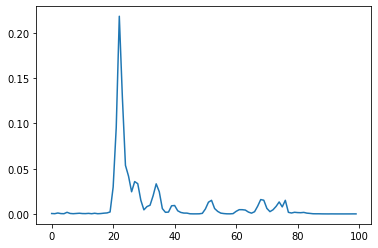

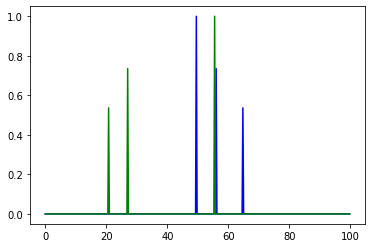

['CID100866999', 'kic10661783']


/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


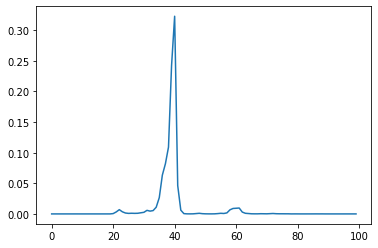

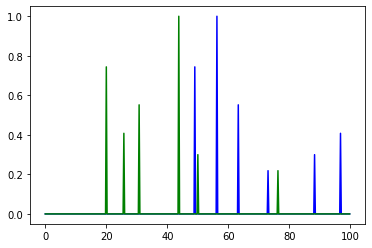

['CID100866999', 'kic10661783', 'HD172189']


/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


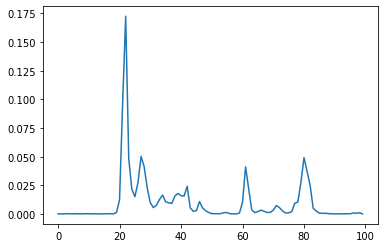

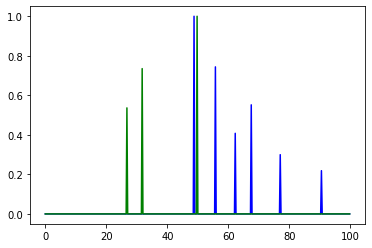

['CID100866999', 'kic10661783', 'HD172189', 'KIC9851944']


/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


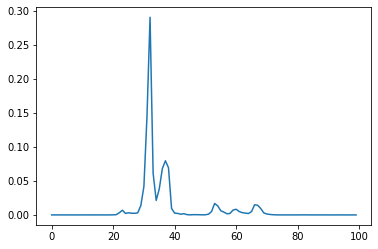

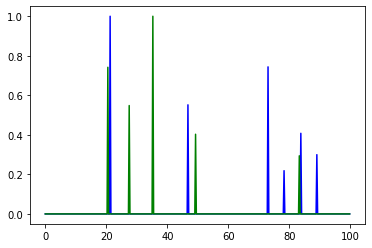

['CID100866999', 'kic10661783', 'HD172189', 'KIC9851944', 'KIC3858884']


/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


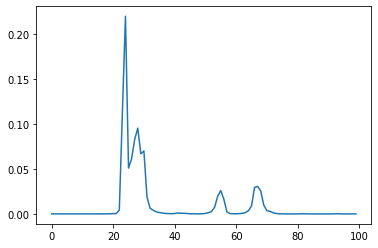

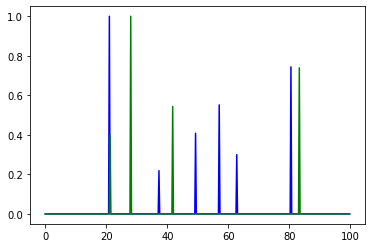

['CID100866999', 'kic10661783', 'HD172189', 'KIC9851944', 'KIC3858884', 'HD15082']


/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


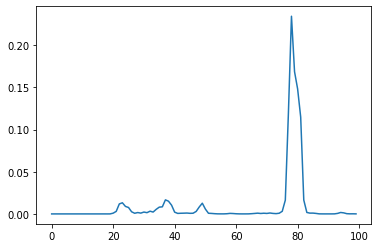

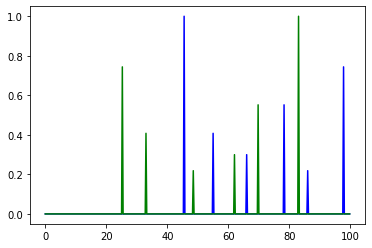

['CID100866999', 'kic10661783', 'HD172189', 'KIC9851944', 'KIC3858884', 'HD15082', 'KIC10080943']


/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


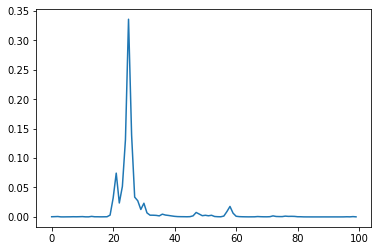

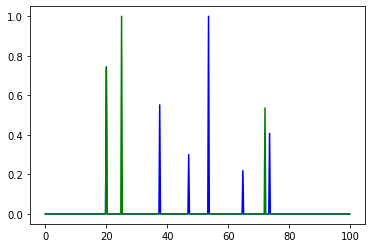

['CID100866999', 'kic10661783', 'HD172189', 'KIC9851944', 'KIC3858884', 'HD15082', 'KIC10080943', 'kic4544587']


/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


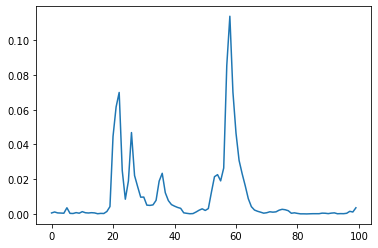

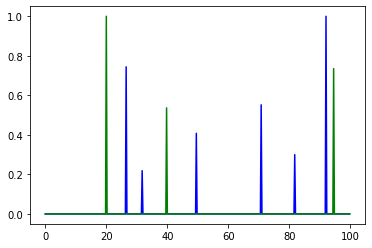

['CID100866999', 'kic10661783', 'HD172189', 'KIC9851944', 'KIC3858884', 'HD15082', 'KIC10080943', 'kic4544587', 'KIC8262223']


/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


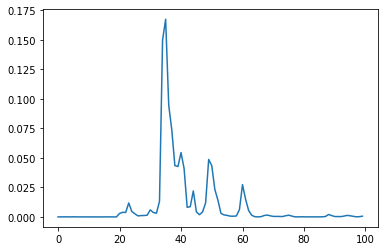

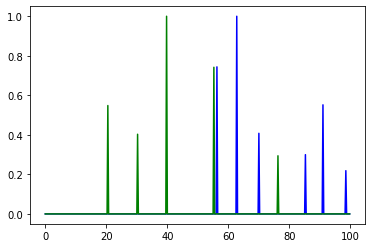

['CID100866999', 'kic10661783', 'HD172189', 'KIC9851944', 'KIC3858884', 'HD15082', 'KIC10080943', 'kic4544587', 'KIC8262223', 'CID105906206']


/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


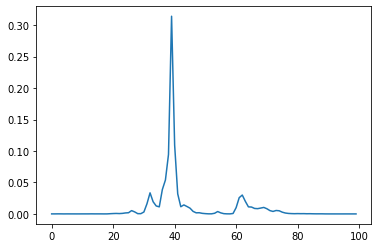

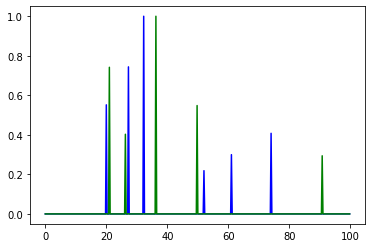

['CID100866999', 'kic10661783', 'HD172189', 'KIC9851944', 'KIC3858884', 'HD15082', 'KIC10080943', 'kic4544587', 'KIC8262223', 'CID105906206', 'HD159561']


/home/roberto/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


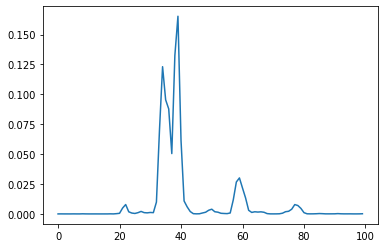

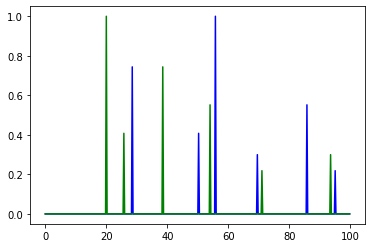

[-34   1   3   6  -5  -2 -27 -16 -42  19   1]
-8.727272727272727
394.72727272727275
[22, 40, 22, 32, 24, 78, 25, 58, 35, 39, 39]
[56, 39, 19, 26, 29, 80, 52, 74, 77, 20, 38]
['CID100866999', 'kic10661783', 'HD172189', 'KIC9851944', 'KIC3858884', 'HD15082', 'KIC10080943', 'kic4544587', 'KIC8262223', 'CID105906206', 'HD159561']


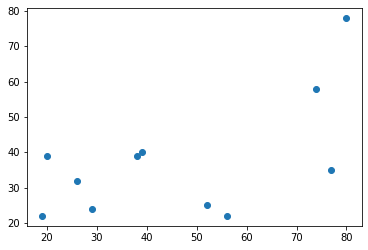

In [9]:
x = []
y = []
l = []
for star in ds_stars:
    target = np.where(star[2].numpy().flat == 1)[0].flat[0]
    l.append(star[0].numpy()[0].decode("utf-8"))
    probs = sepconv_mod.model.predict_proba(star[1])[0]

    print(l)
    plt.plot(probs)
    plt.show()

    plt.plot(np.arange(0, 100, 0.25), star[1][0, :, 0], label="dft", color="blue")
    # plt.plot(x, star[1][0, :, 1], label="hod", color="orange", alpha=0.5)
    plt.plot(np.arange(0, 100, 0.25), star[1][0, :, 1], label="ac", color="green")
    plt.show()
    peaks, _ = find_peaks(probs, height=0, distance=5)
    peaks_width = peak_widths(probs, peaks)
    peaks_sorted_by_prob = np.sort(probs[peaks])[::-1]
    best_peak, best_peak_width = get_peak_width(
        0, peaks, peaks_width, peaks_sorted_by_prob
    )
    x.append(best_peak)
    y.append(target)

plt.scatter(y, x, label=l)
print(np.asarray(x) - np.asarray(y))
print(np.mean(np.asarray(x) - np.asarray(y)))
print(np.mean(np.power(np.asarray(x) - np.asarray(y), 2)))
print(x)
print(y)
print(l)

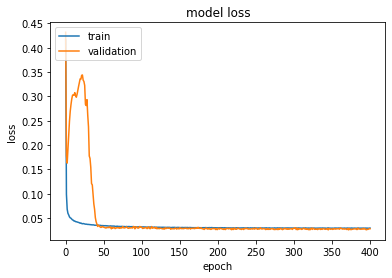

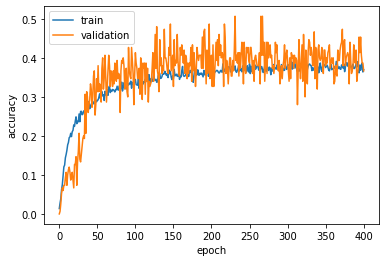

In [10]:
plt.plot(results["loss"])
plt.plot(results["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

plt.plot(results["accuracy"])
plt.plot(results["val_accuracy"])
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

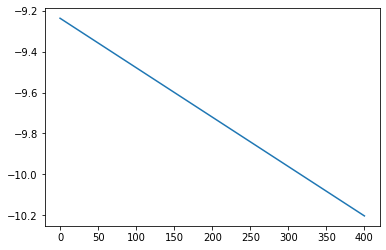

In [11]:
x = [i for i in range(len(results["binaries_errors"]))]
y = results["binaries_errors"]
m, b = np.polyfit(x, y, 1)
plt.plot(x, m * np.asarray(x) + b)

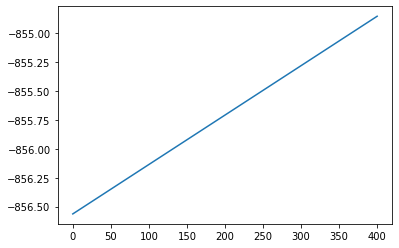

In [12]:
x = [i for i in range(len(results["bedding_errors"]))]
y = results["bedding_errors"]
m, b = np.polyfit(x, y, 1)
plt.plot(x, m * np.asarray(x) + b)

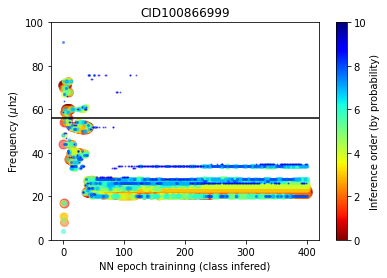

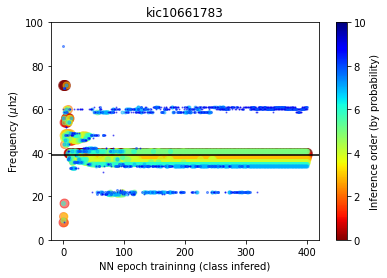

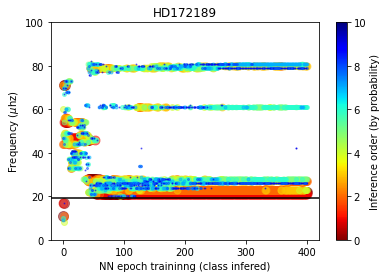

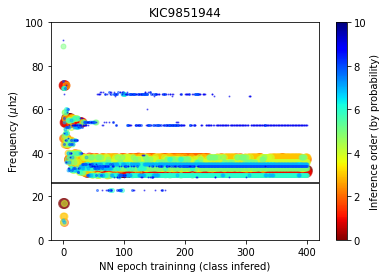

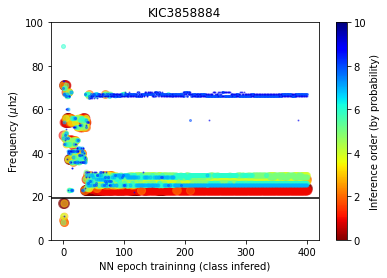

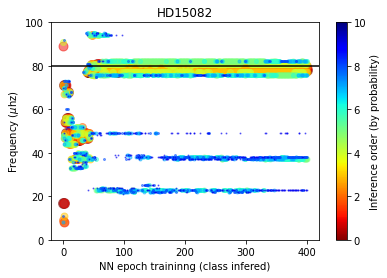

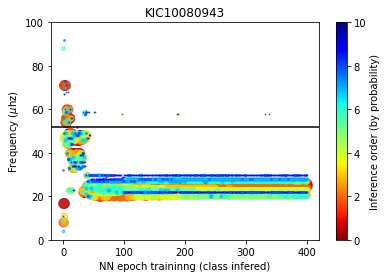

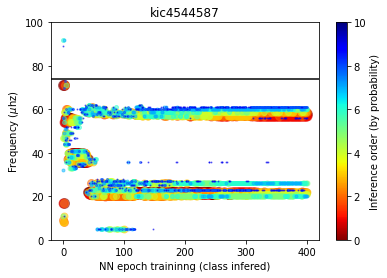

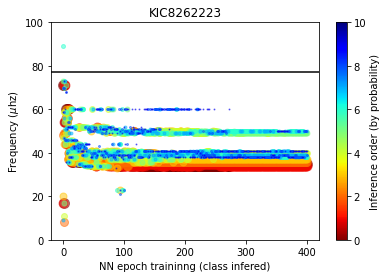

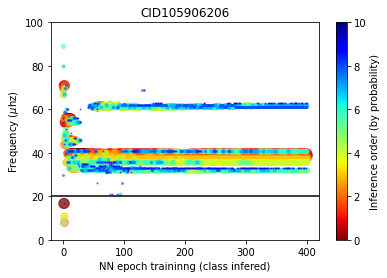

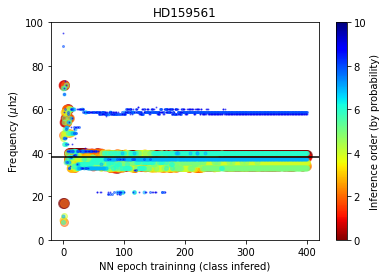

In [13]:
targets = {}
targets["kic10661783"] = {"dnu": 39.0, "dr": 7.0}
targets["KIC9851944"] = {"dnu": 26.0, "dr": 5.3}
targets["HD159561"] = {"dnu": 38.0, "dr": 19.0}
targets["CID100866999"] = {"dnu": 56, "dr": np.nan}
targets["HD15082"] = {"dnu": 80.0, "dr": 14.0}
targets["kic4544587"] = {"dnu": 74.0, "dr": 11.0}
targets["KIC8262223"] = {"dnu": 77.0, "dr": 7.10}
targets["HD172189"] = {"dnu": 19.0, "dr": 4.6}
targets["KIC3858884"] = {"dnu": 19.0, "dr": 1.9}
targets["CID105906206"] = {"dnu": 20.0, "dr": 2.61}
targets["KIC10080943"] = {"dnu": 52.0, "dr": 1.7}

import matplotlib.cm as cm
import matplotlib.colors as mcolors

# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=0, vmax=higher_n_probs)
colormap = plt.get_cmap("jet_r")
# setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(higher_n_probs)

for star in results.keys():
    if star in targets.keys():
        for idx, val in enumerate(range(higher_n_probs)):
            plt.plot(
                results[star][(val,)],
                alpha=0.5,
                marker="o",
                linestyle="None",
                color=colormap(normalize(idx)),
                markersize=higher_n_probs - idx,
            )
        plt.xlabel("NN epoch traininng (class infered)")
        plt.ylabel(r"Frequency ($\mu$hz)")
        plt.axhline(y=targets[star]["dnu"], color="black")
        plt.title(star)
        plt.ylim(0, 100)
        cbar = plt.colorbar(scalarmappaple)
        cbar.set_label("Inference order (by probability)")
        plt.show()